# Semantic Segmentation Using Auto Encoder-Decoder Architecture

In [1]:
from pathlib import Path
import os
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary

from EncoderAgent import EncoderAgent
from SegmentationDataset import SegmentationDataset
import time

In [2]:
board = SummaryWriter(f'ae-runs/ae-semtosemcross-{int(time.time())}')

## Cross Entropy

In [ ]:
VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
CHANNELS = 3
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 128  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('images')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 30  # Number of epochs to train the model
# for Dave: might ask you to change the number of epochs
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train

agent = EncoderAgent(VAL_PERCENTAGE, TEST_NUM, CHANNELS, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE, False)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    board.add_scalar('Accuracy/Training Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Training Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy.append(avg_accuracy)
    validation_loss.append(avg_loss)
    board.add_scalar('Accuracy/Validation Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Validation Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

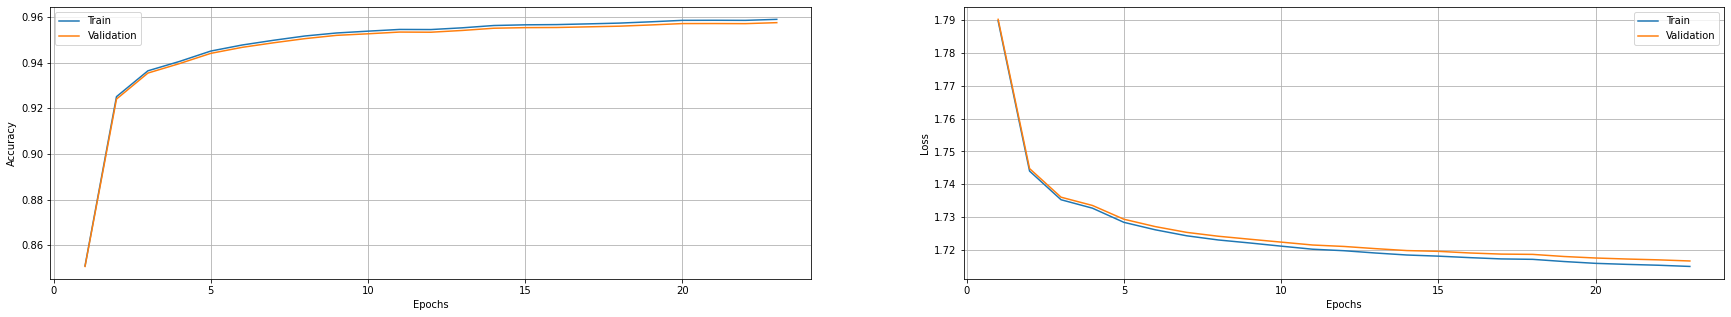

Test Accuracy: 0.955731201171875
Test Loss: 1.715714931488037


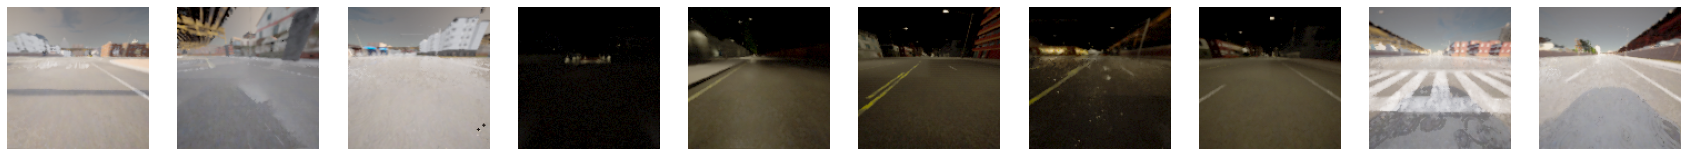

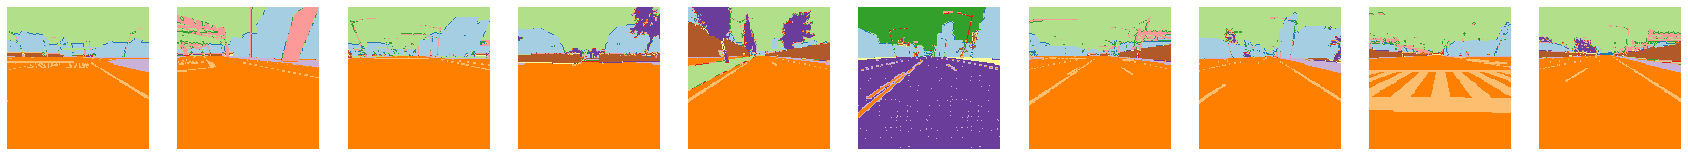

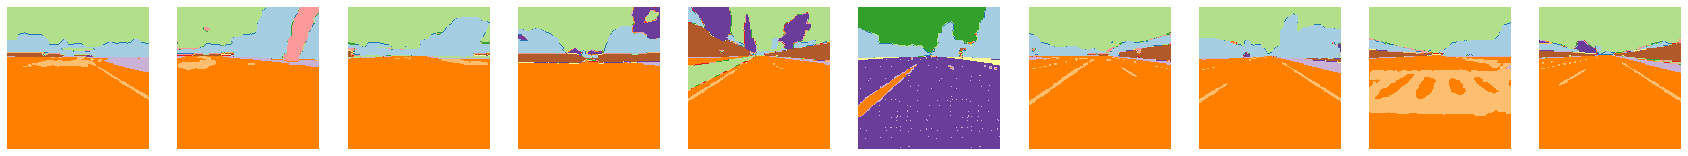

In [4]:
torch.save(agent.model.state_dict(), 'rgb-sem-models/model.pt') 

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy)) + 1, train_accuracy, label='Train')
plt.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

## Tversky Dice Cross Entropy

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          1,568
├─Conv2d: 1-2                            [-1, 64, 32, 32]          32,832
├─BatchNorm2d: 1-3                       [-1, 64, 32, 32]          128
├─Conv2d: 1-4                            [-1, 128, 16, 16]         131,200
├─BatchNorm2d: 1-5                       [-1, 128, 16, 16]         256
├─Conv2d: 1-6                            [-1, 256, 8, 8]           524,544
├─BatchNorm2d: 1-7                       [-1, 256, 8, 8]           512
├─Conv2d: 1-8                            [-1, 512, 4, 4]           2,097,664
├─BatchNorm2d: 1-9                       [-1, 512, 4, 4]           1,024
├─Conv2d: 1-10                           [-1, 64, 1, 1]            524,352
├─ConvTranspose2d: 1-11                  [-1, 512, 4, 4]           524,800
├─BatchNorm2d: 1-12                      [-1, 512, 4, 4]           1,024
├─ConvTranspose2d: 1-13                  [

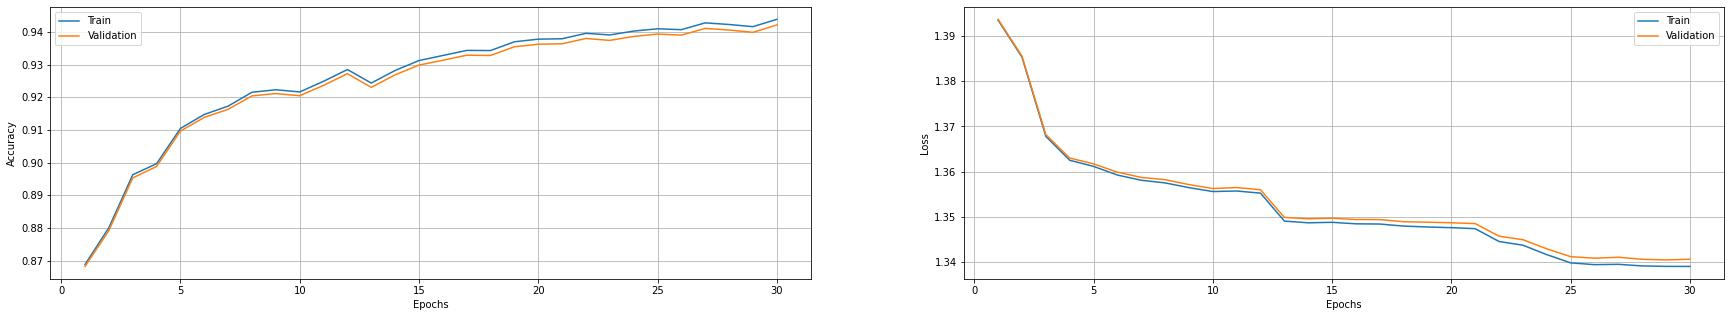

Test Accuracy: 0.948724365234375
Test Loss: 1.3425960540771484


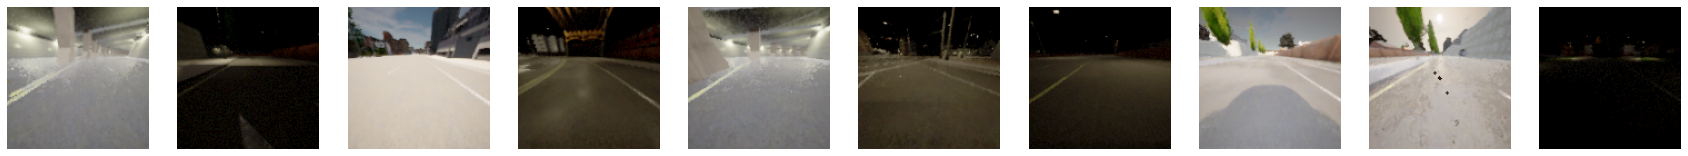

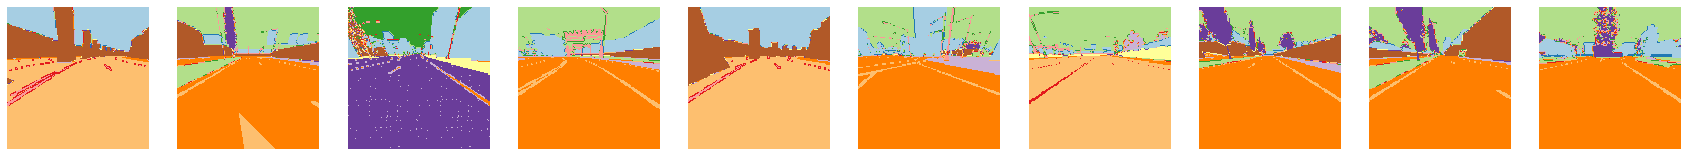

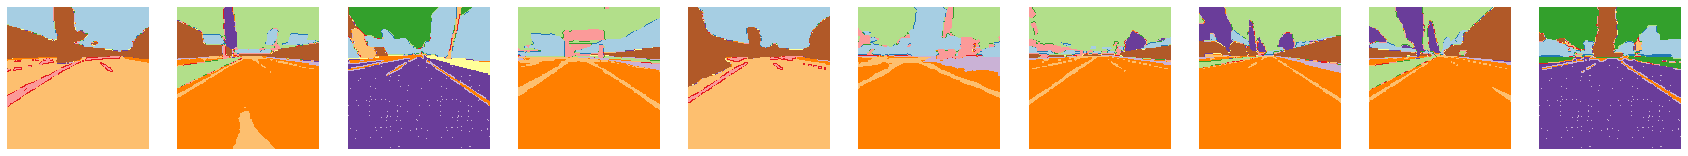

In [3]:
VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
CHANNELS = 3
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 128  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('images')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 30  # Number of epochs to train the model
# for Dave: might ask you to change the number of epochs
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train

agent = EncoderAgent(VAL_PERCENTAGE, TEST_NUM, CHANNELS, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE, True)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    board.add_scalar('Accuracy/Training Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Training Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy.append(avg_accuracy)
    validation_loss.append(avg_loss)
    board.add_scalar('Accuracy/Validation Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Validation Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# Save the model's weights after training is complete
torch.save(agent.model.state_dict(), 'rgb-sem-models/model-tv.pt') # change number if re-running!!!!!

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy)) + 1, train_accuracy, label='Train')
plt.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

## Semantic to Semantic

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 64, 64]          544
├─Conv2d: 1-2                            [-1, 64, 32, 32]          32,832
├─BatchNorm2d: 1-3                       [-1, 64, 32, 32]          128
├─Conv2d: 1-4                            [-1, 128, 16, 16]         131,200
├─BatchNorm2d: 1-5                       [-1, 128, 16, 16]         256
├─Conv2d: 1-6                            [-1, 256, 8, 8]           524,544
├─BatchNorm2d: 1-7                       [-1, 256, 8, 8]           512
├─Conv2d: 1-8                            [-1, 512, 4, 4]           2,097,664
├─BatchNorm2d: 1-9                       [-1, 512, 4, 4]           1,024
├─Conv2d: 1-10                           [-1, 64, 1, 1]            524,352
├─ConvTranspose2d: 1-11                  [-1, 512, 4, 4]           524,800
├─BatchNorm2d: 1-12                      [-1, 512, 4, 4]           1,024
├─ConvTranspose2d: 1-13                  [-1

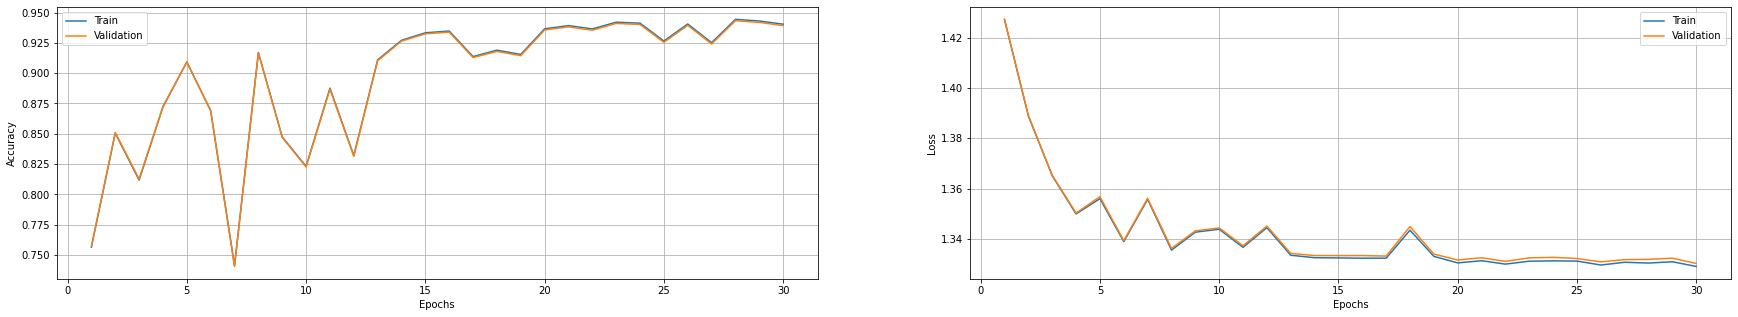

Test Accuracy: 0.942572021484375
Test Loss: 1.331066370010376


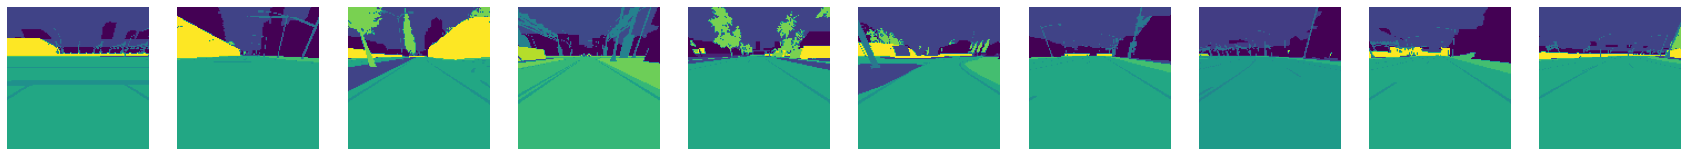

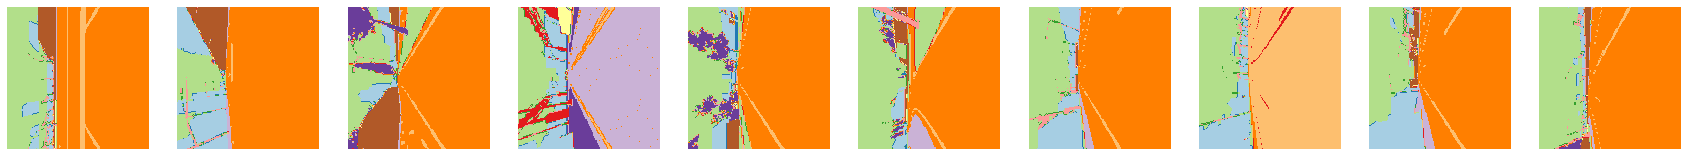

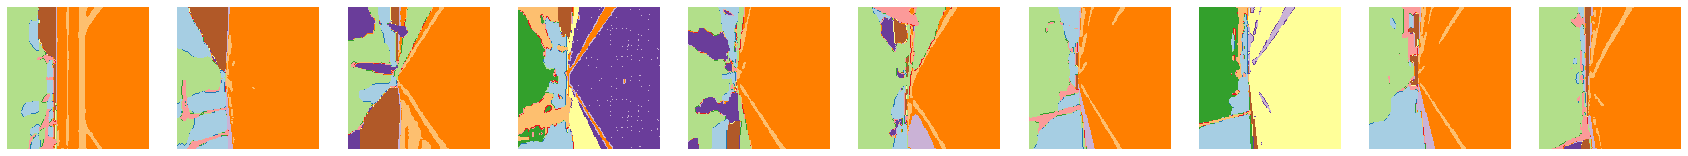

In [3]:
VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
CHANNELS = 1
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 256  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('images')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 30  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train

agent = EncoderAgent(VAL_PERCENTAGE, TEST_NUM, CHANNELS, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE, True, True)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    board.add_scalar('Accuracy/Training Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Training Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy.append(avg_accuracy)
    validation_loss.append(avg_loss)
    board.add_scalar('Accuracy/Validation Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Validation Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (1, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# Save the model's weights after training is complete
torch.save(agent.model.state_dict(), 'ae-models/model-semtosem.pt') # change number if re-running!!!!!

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy)) + 1, train_accuracy, label='Train')
plt.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

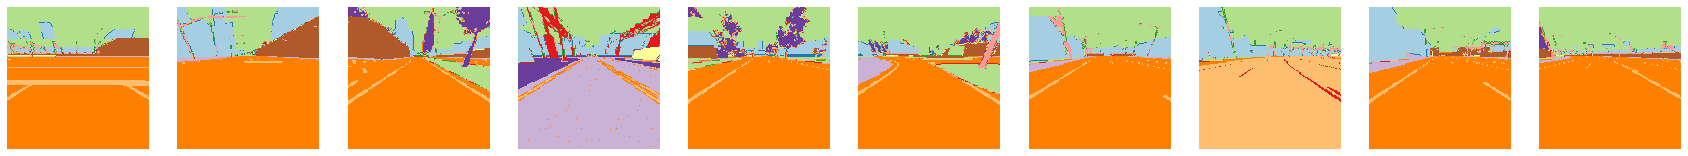

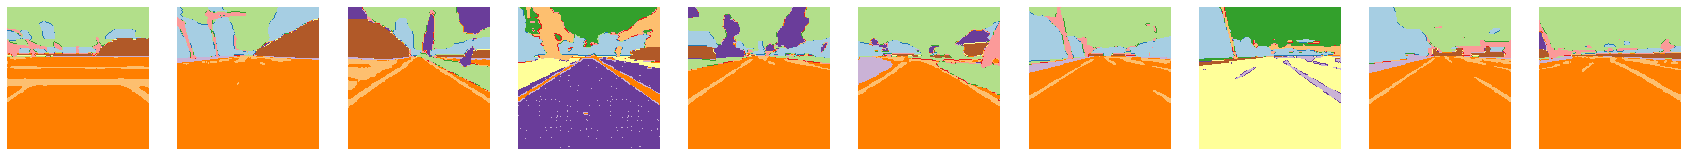

In [4]:
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    temp = np.moveaxis(masks[i], 0, -1)
    m = np.rot90(temp, 3)
    plt.imshow(m, cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    temp = np.moveaxis(preds[i], 0, -1)
    p = np.rot90(temp, 3)
    plt.imshow(p, cmap='Paired')
    plt.axis('off')
plt.show()